In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage
from scipy import stats

import tensorflow as tf
from tensorflow import keras as keras

In [2]:
def G_rate_map(arena_size=[100,100], theta=0., phase=[50,50], lamb=500):
    '''
    Grid cells activity maps as presented in:
    - Blair et al. (2007), equation (1)
    - Almeida et al. (2009), equation (1)
    Params:
        arena_size (tuple of int) : define rate_map dimensions
        theta (float)             : Grid rotation (assume to be either 0°, 20°, or 40°, in degrees)
        Phase (tuple of int)      : Spatial phase of the grid     
        lamb (int)                : Distance between firing fields
    '''

    G = np.zeros(arena_size)
    a = 0.3
    b = -3./2.        
    lambV = (4*np.pi)/(np.sqrt(3*lamb))
    theta = np.radians(theta)

    for ind, val in np.ndenumerate(G):

        tmp_g = 0
        for i in np.deg2rad(np.linspace(-30,90,3)):
            u_f = (np.cos(i+theta),np.sin(i+theta))
            dist = (ind[0]-phase[0],ind[1]-phase[1])
            tmp_g += np.cos( lambV * np.dot(u_f,dist) )
            
        tmp_g = np.exp(np.dot(a,(tmp_g)+b))-1
        G[ind] = tmp_g
        
    
    ## Normalize if for learning and LEC integration effiency 
    if G.min()<0: G += abs(G.min())
    G = (G - G.min())/(G.max()-G.min())
        
    return G

In [3]:
def LEC_rate_map(arena_size=[100,100], filled_perc=0.3):
    
    '''
    Build 'sort of' LEC cells. See Renno-Costa et al. 2010
    These cells have X (filled_perc) number of firing fields randomly spread over the arena
    Params:
        arena_size (tuple of int) : define rate_map dimensions
        filled_perc (float)       : define how much area this cell is receptive to (value from 0 to 1).
    '''
    
    a = np.zeros(36)
    a[: int(filled_perc*25) ] = 1
    np.random.shuffle(a)
    a = a.reshape(6,6)
    
    b = np.zeros((arena_size[0], arena_size[1]))
    
    for i in range(arena_size[0]):
        for j in range(arena_size[1]):
            idx1 = i * len(a) / arena_size[0]
            idx2 = j * len(a) / arena_size[1]
            b[i][j] = a[idx1][idx2]

    arena = scipy.ndimage.filters.gaussian_filter(b, 4)
    arena *= 0.6
    
    return arena

In [4]:
n_grid = 70
n_lec = 230

arena_size = [50,50]

grid_data = []
for ii in range(n_grid):
    lamb  = np.random.randint(500,2000)
    phase = np.random.randint(0,arena_size[0],2)  ## This is assuming arena is a square
    g = G_rate_map(arena_size=arena_size, phase=phase, lamb=lamb)
    grid_data.append( g.flatten()  )
grid_data = np.array(grid_data)


lec_1_data = []
for ii in range(n_lec):
    l = LEC_rate_map(arena_size=arena_size, filled_perc=0.2)
    lec_1_data.append( l.flatten()  )
lec_1_data = np.array(lec_1_data)

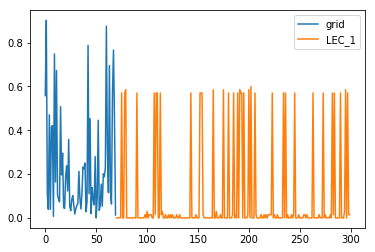

In [5]:

total_positions = arena_size[0] * arena_size[1]
pos = 0  ## position index

## The input vector containing grid and LEC_1 cells at a given position
input_v = np.hstack((grid_data[:,pos] , lec_1_data[:,pos]))  

plt.plot( np.arange(grid_data.shape[0]), input_v[:grid_data.shape[0]], label='grid')
plt.plot( np.arange(grid_data.shape[0],grid_data.shape[0]+ lec_1_data.shape[0] ), input_v[grid_data.shape[0]:], label='LEC_1')
plt.legend()


In [3]:
# Make data structure combining both MEC and LEC_1
data = np.vstack((grid_data , lec_1_data))
data = data.T

NameError: name 'np' is not defined

In [7]:
neurons_softmax = 50

model = keras.Sequential([
keras.layers.Dense(200, activation=tf.nn.relu, input_shape=(data.shape[1],)),
# keras.layers.Dense(100, activation=tf.nn.relu),
keras.layers.Dense(neurons_softmax, activation=tf.nn.relu),
keras.layers.Softmax(),
keras.layers.Dense(200, activation=tf.nn.relu),
keras.layers.Dense(data.shape[1])
])

optimizer = tf.train.RMSPropOptimizer(0.001)

model.compile(loss='mse',
            optimizer=optimizer,
            metrics=['mae'])

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               60200     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
softmax (Softmax)            (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 200)               10200     
_________________________________________________________________
dense_4 (Dense)              (None, 300)               60300     
Total params: 155,850
Trainable params: 155,850
Non-trainable params: 0
_________________________________________________________________


In [9]:
idx = np.arange(data.shape[0])
np.random.shuffle(idx)

In [10]:
EPOCHS = 1000
history = model.fit(data[idx], data[idx], epochs=EPOCHS, validation_split=0.2, verbose=0)

In [1]:
for kk in history.history.keys():
    plt.plot(  history.epoch[5:], history.history[kk][5:] )
    plt.title(kk)
    plt.show()

NameError: name 'history' is not defined

# Test Error by including LEC_2 cells

In [12]:
## Build a new LEC context (LEC_2)
lec_2_data = []
for ii in range(n_lec):
    l = LEC_rate_map(arena_size=arena_size, filled_perc=0.2)
    lec_2_data.append( l.flatten()  )
lec_2_data = np.array(lec_2_data)

In [13]:
# Make a new data structure combining both MEC and LEC_2
data2 = np.vstack((grid_data , lec_2_data))
data2 = data2.T

# Morphing remapping analysis
#### Let the agent run throughout the arena at multiple morphing conditions (i.e., progressively changing from the LEC1 to LEC2)

In [15]:
add_noise = True  ## Add noise to the input data

all_heat_maps = []

for dd in np.linspace(0,1,7):


    new_data = np.zeros_like(data)

    idx = np.arange(data.shape[0])
    np.random.shuffle(idx)

    new_data[ idx[ int(idx.size*dd) : ]  ] = data[ idx[ int(idx.size*dd) :] ]
    new_data[ idx[ : int(idx.size*dd) ]  ] = data2[ idx[ : int(idx.size*dd)  ] ]
    
    
    if add_noise:
        new_data += np.random.uniform(-new_data.mean()*7, new_data.mean()*7, new_data.shape)
    
    
    ## COMPUTE THE ACTIVATION HEATMAPS FOR SOFTMAX LAYER WHILE NAVIGATING THROUGH THE WHOLE ARENA ###################

    heatmaps = np.zeros((neurons_softmax,50,50))      # activations from neurons in SoftMax layer for the whole 50x50 arena

    m2 = tf.keras.Model(inputs=model.input, outputs=model.get_layer('softmax').output)  # the way to get a layer's output in Keras

    for pos in range(data.shape[0]):                  # go through the whole arena

        out = m2.predict(np.array([new_data[pos]]))       # activate network and get SoftMax outputs
        heatmaps[:, pos/50, pos%50] += out.ravel()    # save the outputs



    all_heat_maps.append(heatmaps)

In [16]:
all_heat_maps = np.array(all_heat_maps)

In [17]:
pv_corr = []
pv_diff = []
for i in range(all_heat_maps.shape[0]):
    pv_corr.append( stats.pearsonr( all_heat_maps[0].flatten() , all_heat_maps[i].flatten() )[0] )
    
    
pv_corr = np.array(pv_corr)    

In [18]:
new_heat = np.copy(all_heat_maps.reshape(7,50,50*50))

pv_corr_2 = []

for i in range(new_heat.shape[0]):
    
    tmp_pv_corr_2 = []
    
    for pos in range(new_heat.shape[2]):
    
        tmp_pv_corr_2.append( stats.pearsonr( new_heat[i,:,pos] , new_heat[0,:,pos]  )[0] )
        
    pv_corr_2.append( np.mean(tmp_pv_corr_2) )
    
    
pv_corr_2= np.array(pv_corr_2)

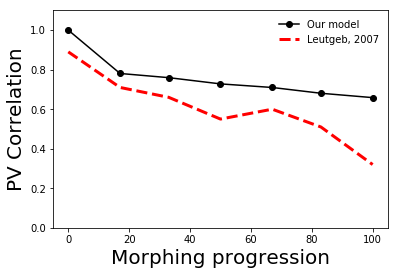

In [19]:
pvcorr_leutgeb = [0.89, 0.71, 0.66, 0.55, 0.6, 0.51, 0.32]
morph_perc = [0, 17,33,50,67,83,100]


# plt.figure(figsize=(6,9))
# 
# plt.plot(morph_perc, pv_corr, '-ok')
plt.plot(morph_perc, pv_corr_2, '-ok', label="Our model")
plt.plot(morph_perc, pvcorr_leutgeb, '--r', linewidth=3, label="Leutgeb, 2007")

plt.ylabel("PV Correlation", fontsize=20)
plt.xlabel("Morphing progression", fontsize=20)

plt.ylim(0,1.1)

plt.legend(frameon=False)

# plt.tight_layout()
# plt.savefig('/Users/diogo/devel/hpc_autoencoder/figures/remapping.jpg', dpi=300)

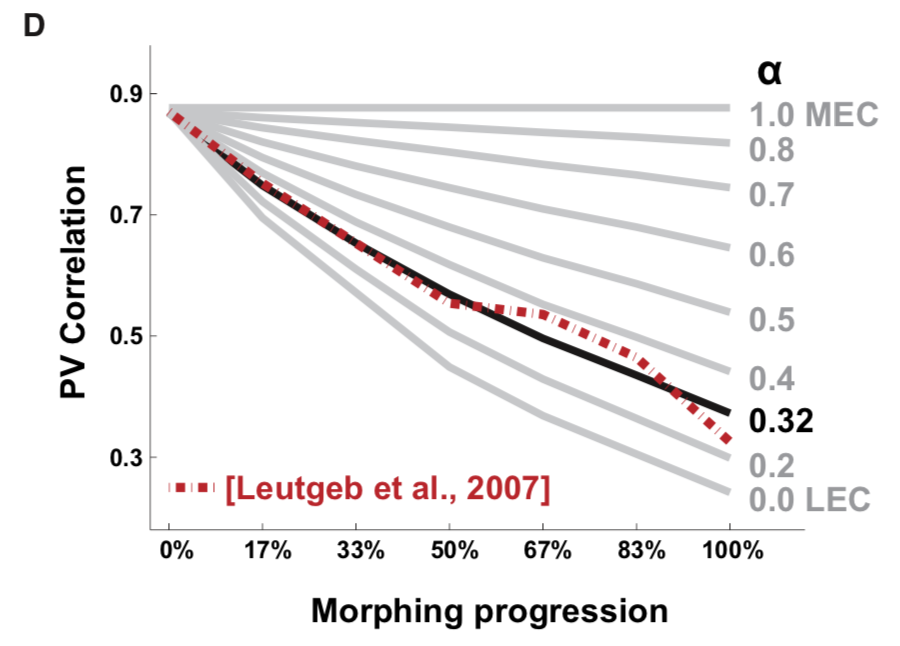